## Convert imaging data

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')

In [73]:
from showit import image

In [74]:
import thunder

In [75]:
from numpy import array, concatenate
from os.path import join, exists
from os import mkdir, makedirs
import json

###Set directory and session information

In [89]:
#base = '/tier2'
base = '/Volumes'
directory = base + '/freeman/Nick/lfov.calibration'

####General imaging parameters
- Number of averages per frame
- Average power
- Frame rate

####For each roi:
    - XY center in mm
    - XY size in mm
    - XY pixels #
    - list of z depths in mm

Multiple scanfields per ROI, want to seperate into different ROIs

when only one scanfield defined it is covers whole range

when discrete plane mode only that plane defined

In [77]:
def load(path, engine=None):
    #Load metadata, tiff stacks, and reshape
    meta = loadMeta(path + '.json')
    if meta['merge']:
        order = meta['order']
    else:
        order = False
    data = loadTiff(path + '.tif', meta['nplanes'], meta['nrois'], meta['nlines'], order, engine=engine)
    meta = mergeMeta(meta)
    meta['shape'] = data.shape
    return meta, data

In [78]:
def loadMeta(path):
    files = glob(path)
    assert(len(files))
    with open(files[0]) as fid:
        header = json.load(fid)
    
    meta = parse(header)
    return meta

In [79]:
from numpy import multiply, argsort
from glob import glob

In [80]:
def parse(header):
    FOVmm = [590/0.09665194185/1000, 6293.0/1000]
    
    meta = {}
    assert(header['hRoiManager']['mroiEnable'])

    if header['hFastZ']['enable']:
        depths = header['hFastZ']['userZs']
    else:
        depths = header['hStackManager']['zs']
    
    if type(depths) == int:
        meta['nplanes'] = 1
    else:
        meta['nplanes'] = len(depths)

    meta['depths'] = depths
    
    meta['averaging'] = header['hStackManager']['framesPerSlice']
    meta['power'] = header['hBeams']['powers']

    meta['volumeRate'] = header['hRoiManager']['scanFrameRate']

    meta['rois'] = [dict([('center', rescale(roi['scanfields']['centerXY'], FOVmm)),
            ('size', rescale(roi['scanfields']['sizeXY'], FOVmm)),
            ('npixels',roi['scanfields']['pixelResolutionXY']),
            ('depths', roi['zs'])]) 
             for roi in header['imagingRoiGroup']['rois']]
    meta['nrois'] = len(meta['rois'])
    meta['nlines'] = meta['rois'][0]['npixels'][1]
    
    meta['order'] = argsort([roi['center'][0] for roi in meta['rois']])
    meta['merge'] = check_order(meta['rois'], meta['order'])
    
    return meta

In [81]:
def rescale(x,FOVmm):
    return multiply(x,FOVmm).tolist()

In [82]:
def check_order(rois, order):
    diff = array([abs((rois[order[i]]['center'][0] + rois[order[i]]['size'][0]/2) 
    - (rois[order[i+1]]['center'][0] - rois[order[i+1]]['size'][0]/2)) for i in range(len(order)-1)])
    return diff.mean() < .02

In [83]:
def mergeMeta(meta):
    if meta['merge']:
        center = array([x['center'] for x in meta['rois']]).mean(axis=0)
        size = array([x['size'] for x in meta['rois']]).mean(axis=0)
        size[0] = size[0]*meta['nrois']
        npixels = array([x['npixels'] for x in meta['rois']]).mean(axis=0)
        npixels[0] = npixels[0]*meta['nrois']
        depths = array([x['depths'] for x in meta['rois']]).mean(axis=0)
        meta['rois'] = [dict([('center', list(center)),
            ('size', list(size)),
            ('npixels',list(npixels)),
            ('depths', depths)])]        
        meta['nrois'] = 1

    del meta['merge']
    del meta['order']
    del meta['nlines']
    
    return meta

In [84]:
def loadTiff(path, nplanes, nrois, nlines, order=False, engine=None):
    #Loads raw data from Tiff and reshapes
    data = thunder.images.fromtif(path, nplanes=nplanes, engine=engine)
    return data.map(lambda x : reshape(x, nrois, nlines, order))

In [85]:
def split(oim, nrois, nlines):
    ## Takes a single 2-dim plane and reshapes it according to nrois, nlines
    assert oim.ndim == 2
    
    if nrois > 1:
        ntotal = oim.shape[0]
        ngap = (ntotal - nlines*nrois)/(nrois-1)
        return array([oim[nlines*i + ngap*i: nlines*(i + 1) + ngap*i, :] for i in range(nrois)])
    else:
        return oim

In [86]:
def merge(oim, order):
    ## Takes a single 3-dim volume and merges along x dimension into a single plane
    if type(order) != bool:
        assert oim.ndim == 3
        assert len(order) == oim.shape[0]
        return oim[order].transpose((1, 0, 2)).reshape([oim.shape[1], -1])
    else:
        return oim

In [87]:
def reshape(oim, nrois, nlines, order):
    ## Takes a 2-dim plane / 3-dim volume and splits and merges
    if oim.ndim == 3:
        return array(map(lambda x : merge(split(x, nrois, nlines), order), oim))
    else:
        return merge(split(oim, nrois, nlines), order)

## Load data

In [150]:
key = '2016-04-16'
name = 'anm-0335049-2'
path = join(directory, 'unprocessed', 'images', key, name)
print path
print exists(path)

/Volumes/freeman/Nick/lfov.calibration/unprocessed/images/2016-04-16/anm-0335049-2
True


In [151]:
meta, data = load(path + '/trial*', engine = None)

KeyboardInterrupt: 

In [ ]:
meta

## Inspect data

In [138]:
mean = data.mean().toarray()

In [139]:
mean.shape

(28, 992, 1024)

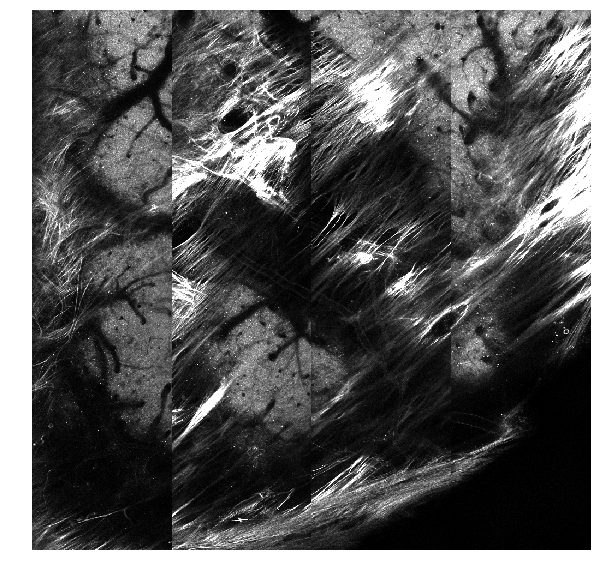

In [140]:
img = mean[1,:,:]
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
im = image(img, clim=(0, 3.5*img.mean()), ax=ax)

##Save binary images

In [141]:
savepath = join(directory, 'reprocessed', name, key, 'images')
if not exists(savepath):
    makedirs(savepath)

In [142]:
data.tobinary(savepath, overwrite=True)

##Save summary data

###Meta data

In [143]:
savepath = join(directory, 'reprocessed', name, key, 'summary')
if not exists(savepath):
    makedirs(savepath)

In [144]:
with open(savepath + '/meta.json', 'w') as fid:
    json.dump(meta, fid, indent=2)

###Raw tiffs

In [145]:
from skimage.io import imsave

In [146]:
imsave(savepath+'/raw.tif', mean.astype('float32'), plugin='tifffile', photometric='minisblack')

###Normalized tiffs

In [147]:
def normalize(oim):
    # normalizes 3D image across first axis
    assert oim.ndim == 3
    
    means = oim.mean(axis=(1, 2), dtype='float32')
    maximum = means.max()
    return array([oim[i]*maximum/means[i] for i in range(oim.shape[0])])

In [148]:
#norm = data[:,:,3,:,:].squeeze().map(normalize)
#norm = data.map(normalize)
norm = normalize(mean).astype('float32')
#.toarray().squeeze()

In [149]:
imsave(savepath+'/raw-norm.tif', norm, plugin='tifffile', photometric='minisblack')